In [ ]:
#!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import torch

# Download latest version
path = kagglehub.dataset_download("arashnic/book-recommendation-dataset")
# path = '../dataset'

books = pd.read_csv(f"{path}/Books.csv")
ratings = pd.read_csv(f"{path}/Ratings.csv")
users= pd.read_csv(f"{path}/Users.csv")

book_of_interest = 'the lord of the rings'

/tmp/ipython-input-2-3960183323.py:11: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv(f"{path}/Books.csv")


Find LOTR books in the database

In [6]:
lotr_books = books[books["Book-Title"].str.contains(book_of_interest, case=False)]
lotr_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
780,0345339711,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,1986,Del Rey,http://images.amazon.com/images/P/0345339711.0...,http://images.amazon.com/images/P/0345339711.0...,http://images.amazon.com/images/P/0345339711.0...
1571,0345339703,The Fellowship of the Ring (The Lord of the Ri...,J.R.R. TOLKIEN,1986,Del Rey,http://images.amazon.com/images/P/0345339703.0...,http://images.amazon.com/images/P/0345339703.0...,http://images.amazon.com/images/P/0345339703.0...
3354,0345339681,The Hobbit : The Enchanting Prelude to The Lor...,J.R.R. TOLKIEN,1986,Del Rey,http://images.amazon.com/images/P/0345339681.0...,http://images.amazon.com/images/P/0345339681.0...,http://images.amazon.com/images/P/0345339681.0...
4206,0345339738,"The Return of the King (The Lord of the Rings,...",J.R.R. TOLKIEN,1986,Del Rey,http://images.amazon.com/images/P/0345339738.0...,http://images.amazon.com/images/P/0345339738.0...,http://images.amazon.com/images/P/0345339738.0...
6060,0618129022,The Lord of the Rings (Movie Art Cover),J.R.R. Tolkien,2001,Houghton Mifflin Company,http://images.amazon.com/images/P/0618129022.0...,http://images.amazon.com/images/P/0618129022.0...,http://images.amazon.com/images/P/0618129022.0...
6866,0345340426,The Hobbit and The Lord of the Rings,J.R.R. TOLKIEN,1986,Del Rey,http://images.amazon.com/images/P/0345340426.0...,http://images.amazon.com/images/P/0345340426.0...,http://images.amazon.com/images/P/0345340426.0...
11083,0618129014,The Lord of the Rings (Movie Art Cover),J. R. R. Tolkien,2001,Houghton Mifflin Company,http://images.amazon.com/images/P/0618129014.0...,http://images.amazon.com/images/P/0618129014.0...,http://images.amazon.com/images/P/0618129014.0...
12761,0618002243,"The Return of the King (The Lord of The Rings,...",J. R. R. Tolkien,1999,Houghton Mifflin Company,http://images.amazon.com/images/P/0618002243.0...,http://images.amazon.com/images/P/0618002243.0...,http://images.amazon.com/images/P/0618002243.0...
12762,0618002235,"The Two Towers (The Lord of the Rings, Part 2)",J. R. R. Tolkien,1999,Houghton Mifflin Company,http://images.amazon.com/images/P/0618002235.0...,http://images.amazon.com/images/P/0618002235.0...,http://images.amazon.com/images/P/0618002235.0...
12763,0618002227,The Fellowship of the Ring (The Lord of the Ri...,J. R. R. Tolkien,1999,Houghton Mifflin Company,http://images.amazon.com/images/P/0618002227.0...,http://images.amazon.com/images/P/0618002227.0...,http://images.amazon.com/images/P/0618002227.0...


Books

Get rid of images and nan values

In [34]:
books.drop(['Image-URL-S', 'Image-URL-L'], axis=1, inplace=True) # leave one image column for later visualization
print(books.isna().any(axis=1).sum()) # there only 4 incomplete rows, I'll simply drop them
books.dropna(inplace=True)

4


I will deduplicate on (Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher') tuples later, as there may be ratings that I would otherwise get rid off if i do deduplication in books table now

In [35]:
num_duplicates = books.duplicated(['Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']).sum()
print(f"Duplicate books {100*num_duplicates/len(books):.2f}%")

Duplicate books 0.34%


In [36]:
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')
print(books['Year-Of-Publication'].isna().sum())
books = books.fillna({'Year-Of-Publication': books['Year-Of-Publication'].mean()}) # impute with mean

3


Text(0.5, 1.0, 'Top Authors')

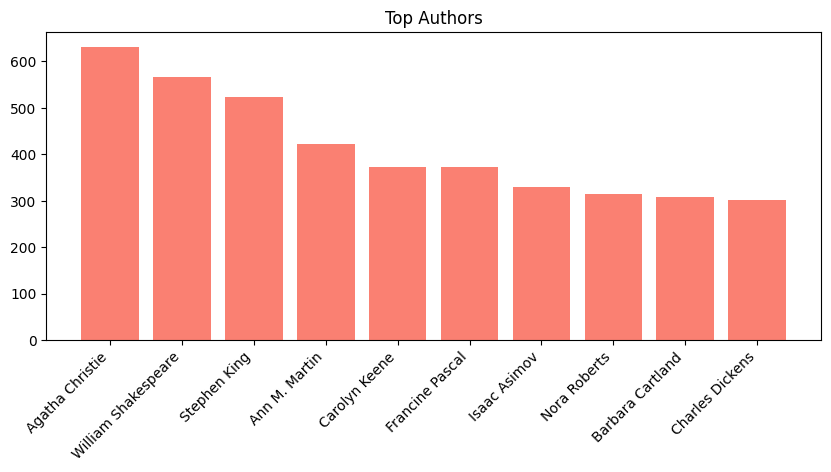

In [37]:
author_count = books['Book-Author'].value_counts().reset_index(name='Count').sort_values('Count', ascending=False).head(10)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.bar(author_count['Book-Author'], author_count['Count'], color='salmon')
ax.set_xticks(range(len(author_count)))
ax.set_xticklabels(author_count['Book-Author'], rotation=45, ha='right')
ax.set_title('Top Authors')

Users

In [10]:
users['Location'].nunique()

57339

In [19]:
users['Location'] = users['Location'].apply(lambda x: x.split(',')[-1].lower().strip()) # replace (city, region, country) with just the country
users['Location'] = users['Location'].str.replace(r'[!./@"]', '', regex=True)
users['Location'].nunique()

617

In [23]:
pd.Series(users['Location'].unique()).loc[lambda s: s.str.contains('spa', case=False, na=False)]

,0
5,spain
43,españa
61,somewherein space
130,space
152,queenspark
248,catalunya spain
281,espaã?â±a
310,espaã±a
487,espanha galiza


Locations are still pretty dirty. There are around 200 recognized countries in the world and the data we have tells us that there are 617. There are many invalid places like "somewhere in space" or country names not written in english, that have a typo, written in incorrect format and so on...

In [24]:
users.isna().sum()

,0
User-ID,0
Location,0
Age,110762


In [28]:
print(f"Missing ages {100*users['Age'].isna().sum() / len(users['Age']):.2f}%")

Missing ages 39.72%


In [38]:
users.fillna({'Age': 0}, inplace=True)
users.loc[users['Age'] <= 3, 'Age'] = 0
mean = users['Age'][users['Age'] <= 3].mean()
users['Age'] = users['Age'].replace(0, mean) # impute by mean

Ratings

In [ ]:
ratings.head()

In [ ]:
plt.hist(ratings['Book-Rating'], color='salmon', bins=range(1, 12), edgecolor='black', align='left')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of explicit book ratings')
plt.xticks(range(1, 11))
plt.show()

We have explicit and implicit feedback...

In [44]:
ratings_explicit = ratings[ratings['Book-Rating'] != 0] # choose only explicit ratings for now

book_ratings = ratings_explicit.merge(books.drop('Image-URL-M', axis=1), on='ISBN')
implicit = 1 - len(book_ratings) / len(ratings)
print(f"Implicit ratings percentage: {implicit:.2%}")

Implicit ratings percentage: 66.62%


Get the user-book rating matrix

In [57]:
complete_df = book_ratings.merge(users, on="User-ID") # create a triplet dataframe of users;rankings;books dataframes
complete_df.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location,Age
0,276726,0155061224,5,Rites of Passage,Judith Rae,2001.0,Heinle,usa,0.0
1,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press,croatia,16.0
2,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press,croatia,16.0
3,276744,038550120X,7,A Painted House,JOHN GRISHAM,2001.0,Doubleday,usa,0.0
4,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003.0,HarperTorch,usa,25.0


Now that we have the metadata combined with ratings, we can deduplicate and clean up the data some more

In [60]:
complete_df['Book-Title'] = complete_df['Book-Title'].str.lower()
complete_df['Book-Author'] = complete_df['Book-Author'].str.lower()

In [61]:
complete_df.duplicated({'Book-Title', 'Book-Author', 'User-ID'}).sum() / len(complete_df)

np.float64(0.002376002376002376)

Calculate the sparsity of our user-book ratings

In [ ]:
def compute_sparsity(ratings_df):
    n_users = ratings_df['User-ID'].nunique()
    n_books = ratings_df['ISBN'].nunique()
    print(f"Number of users: {n_users}")
    print(f"Number of books: {n_books}")

    total_possible = n_users * n_books
    actual_ratings = len(ratings_df)
    print(f"Actual ratings: {actual_ratings}")
    print(f"Total possible ratings: {total_possible}")

    sparsity = 1 - (actual_ratings / total_possible)
    print(f"Sparsity of the user-book ratings: {sparsity:.7f}")

    return sparsity

In [ ]:
sparsity = compute_sparsity(complete_df)

Our data is very sparse. To try and mitgate this, we can filter out less popular books and inexperienced users

In [ ]:
mask_users = complete_df.groupby('User-ID')['Book-Rating'] \
                        .transform('size') >= 1
mask_books = complete_df.groupby('ISBN')['Book-Rating'] \
                         .transform('size') >= 10

filtered_df = complete_df[mask_users & mask_books]

In [ ]:
sparsity = compute_sparsity(filtered_df)

I will train a classical SVD model and use the learned book vectors in latent space to do item to item similarity.

If a root mean square error is around 1.5 on average. We can safely say that the average rating prediction of our model is off by no more than 1.5, since rmse is greater or equal to the mean absolute error

In [ ]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import KFold
from surprise import accuracy

data_df = filtered_df[['User-ID', 'ISBN', 'Book-Rating']].copy()

# create the model from surprise library and perform 5-fold cross-validation
min_c, max_c = data_df['Book-Rating'].min(), data_df['Book-Rating'].max()
reader = Reader(rating_scale=(min_c, max_c))
data = Dataset.load_from_df(data_df, reader)
model = SVD(n_factors=50)

rmse_test, rmse_train = [], []
kf = KFold(n_splits=5, random_state=42, shuffle=True)

for fold, (train, test) in enumerate(kf.split(data)):
    model.fit(train)

    preds = model.test(test)
    rmse_curr = accuracy.rmse(preds)
    rmse_test.append(rmse_curr)

    train_testset = train.build_testset()
    preds = model.test(train_testset)
    rmse_curr = accuracy.rmse(preds, verbose=False)
    rmse_train.append(rmse_curr)

print(f"Mean test set RMSE: {np.mean(rmse_test):.4f}")
print(f"Mean train set RMSE: {np.mean(rmse_train):.4f}")

In [ ]:
import numpy as np

isbn2title = {
    isbn: title.strip().lower()
    for isbn, title in zip(books['ISBN'], books['Book-Title'])
}

inner2title = {}
for inner_id in range(train.n_items):
    try:
        raw_id = train.to_raw_iid(inner_id)
        inner2title[inner_id] = isbn2title.get(raw_id, "").lower()
    except ValueError:
        continue

title2inner = {
    title: iid
    for iid, title in inner2title.items()
    if title
}

def book2book_retrieval(book_title, model, title2inner, inner2title, top_n=10):
    key = book_title.lower()
    if key not in title2inner:
        # find a partial match
        for inner_id, title in inner2title.items():
            if book_title.lower() in title:
                key = title
                break
        else:
            print(f"No match found for '{book_title}'")
            return []
        print(f"No exact match for '{book_title}' found. Showing results for '{key}' instead.")

    inner_id = title2inner[key]

    # cosine sim
    q = model.qi[inner_id]
    q_norm = q / np.linalg.norm(q)
    db_norm = model.qi / np.linalg.norm(model.qi, axis=1, keepdims=True)
    sims = db_norm.dot(q_norm)

    recs = [
        (inner2title[iid], round(score, 3))
        for iid, score in enumerate(sims)
        if iid != inner_id
    ]
    recs.sort(key=lambda x: x[1], reverse=True)
    return recs[:top_n]

In [ ]:
book_of_interest = 'the lord of the rings'
print(title2inner[book_of_interest])

In [ ]:
book2book_retrieval(book_of_interest, model, title2inner, inner2title, top_n=10)

In [ ]:
# data = Loader(filtered_df, config['year_intervals'], config['age_intervals'])
X_df = pd.pivot(data=filtered_df, columns='ISBN', index='User-ID', values='Book-Rating')

In [ ]:
X_df.fillna(0)
X = torch.tensor(X_df.fillna(0).values, dtype=torch.float32)

In [ ]:
print(X.shape)

In [ ]:
I = torch.eye(X.shape[1])
reg = 1e-2 # should be 10 - 100
P_hat = torch.inverse(X.T @ X + reg * I)

In [ ]:
B_hat = I - P_hat * torch.diag(I / torch.diag(P_hat))
B_hat = B_hat.fill_diagonal_(0)
print(B_hat.shape)

In [ ]:
import pickle

with open("model10.pkl", "wb") as f:
    pickle.dump(B_hat, f)

In [ ]:
filtered_df['Book-Title'] = filtered_df['Book-Title'].str.lower()
lotr_books = filtered_df[filtered_df["Book-Title"] == 'the lord of the rings']
lotr_books

In [ ]:
isbn = '0618260250'
column_index = X_df.columns.get_loc(isbn)

print("Column index:", column_index)

In [ ]:
sim = B_hat @ B_hat[3858] # dot product, not cosine similarity

In [ ]:
sim[3858] = float('-inf') # mask out the same index
top_index = sim.argmax().item()
sim.max()

In [ ]:
top_isbn = X_df.columns[top_index]
print("Most similar ISBN:", top_isbn)

In [ ]:
filtered_df[filtered_df.ISBN == '006447108X'].describe()

In [ ]:
# import pickle
#
# with open("models/svd_model/model2.pkl", "wb") as f:
#     pickle.dump(model, f)
#
# with open("models/svd_model/inner2title2.pkl", "wb") as f:
#     pickle.dump(inner2title, f)

Since the feedback is so sparse, I'll try a NN based approach incorporate book and user metadata. For that, I need to do some more data preprocessing

In [ ]:
# split_idx = int(0.8 * len(filtered_df))
# train_df = filtered_df[:split_idx]
# test_df = filtered_df[split_idx:]

# train = torch.utils.data.DataLoader(Loader(train_df, config['year_intervals'], config['age_intervals']),
#                                     batch_size=config['batch_size'], shuffle=True)
# test = torch.utils.data.DataLoader(Loader(test_df, config['year_intervals'], config['age_intervals']),
#                                     batch_size=config['batch_size'], shuffle=False)

# nn_model = Recommender(
#     filtered_df['User-ID'].nunique(),
#     filtered_df['ISBN'].nunique(),
#     filtered_df['Location'].nunique() * len(config['age_intervals']),
#     filtered_df['Book-Author'].nunique() * len(config['year_intervals']))

# optimizer = torch.optim.AdamW(nn_model.parameters(), lr=1e-3, weight_decay=1e-3)

In [ ]:
# for i in range(config['epochs']):
#     nn_model.train()
#     train_losses = []
#     for (x, y) in train:
#         optimizer.zero_grad()
#         y_pred = nn_model(x)
#         metric = torch.sqrt(torch.nn.functional.mse_loss(y_pred.sigmoid() * 10, y))
#         loss = torch.nn.functional.binary_cross_entropy_with_logits(y_pred, y / 10)
#         train_losses.append(metric.item())
#         loss.backward()
#         optimizer.step()

#     nn_model.eval()
#     test_losses = []
#     with torch.no_grad():
#         for (x, y) in test:
#             y_pred = nn_model(x).squeeze(-1)
#             loss = torch.sqrt(torch.nn.functional.mse_loss(y_pred.sigmoid() * 10, y))
#             test_losses.append(loss.item())

#     train_rmse = np.mean(train_losses)
#     test_rmse = np.mean(test_losses)
#     print(f"Epoch {i+1}/{config['epochs']} - Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

In [ ]:
# def book2book_retrieval(book_title, train, model, book2idx, idx2book, top_n=10):
#     key = book_title.lower()
#     if key not in title2inner:
#         # find a partial match
#         for inner_id, title in inner2title.items():
#             if book_title.lower() in title:
#                 key = title
#                 break
#         else:
#             print(f"No match found for '{book_title}'")
#             return []
#         print(f"No exact match for '{book_title}' found. Showing results for '{key}' instead.")

#     inner_id = title2inner[key] # the inner key in this case is actually the ISBN

#     # cosine sim
#     author = train.ratings.loc[train.ratings['ISBN'] == inner_id, 'Book-Author'].iloc[0]
#     year_bin = train.ratings.loc[train.ratings['ISBN'] == inner_id, 'Year-Of-Publication'].iloc[0]
#     sims = model.item_embeddings()

#     recs = [
#         (inner2title[iid], round(score, 3))
#         for iid, score in enumerate(sims)
#         if iid != inner_id
#     ]
#     recs.sort(key=lambda x: x[1], reverse=True)
#     return recs[:top_n]

In [ ]:
# book2book_retrieval()